In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/assign/

Mounted at /content/drive
/content/drive/MyDrive/assign


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import pandas as pd
from collections import defaultdict
import torch.backends.cudnn as cudnn
import random

In [4]:
train_file = np.load('./dataset/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./dataset/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [5]:
class TrajectoryDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=256, output_dim=2, num_layers=2, pred_len=60):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.pred_len = pred_len
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        mean0, std0, mean1, std1, x = self.normalize(x)
        batch_size = x.size(0)
        outputs = []
        _, (h, c) = self.encoder(x)
        decoder_input = torch.zeros(batch_size, 1, 2, device=x.device)
        for _ in range(self.pred_len):
            out, (h, c) = self.decoder(decoder_input, (h, c))
            pred = self.output_layer(out)
            outputs.append(pred)
            decoder_input = pred
        # h = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        # c = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        # for _ in range(self.pred_len):
        #     out, (h, c) = self.encoder(x, (h, c))
        #     out = self.output_layer(out[:, -1, :]).unsqueeze(1)
        #     outputs.append(out[:, :, :2])
        #     x = torch.cat((x, torch.zeros(out.shape, device=x.device)), dim=1)
        outputs = torch.cat(outputs, dim=1)
        return self.denormalize(outputs, mean0, std0, mean1, std1)

    def normalize(self, x):
        mean0 = x[:, :, 0].mean(dim=1, keepdim=True)
        std0 = x[:, :, 0].std(dim=1, keepdim=True)
        x[:, :, 0] = (x[:, :, 0] - mean0) / (std0 + 1e-6)
        mean1 = x[:, :, 1].mean(dim=1, keepdim=True)
        std1 = x[:, :, 1].std(dim=1, keepdim=True)
        x[:, :, 1] = (x[:, :, 1] - mean1) / (std1 + 1e-6)
        return mean0, std0, mean1, std1, x

    def denormalize(self, x, mean0, std0, mean1, std1):
        x[:, :, 0] = x[:, :, 0] * std0 + mean0
        x[:, :, 1] = x[:, :, 1] * std1 + mean1
        return x

In [7]:
obj_dict = defaultdict(list)
train, val = train_data[:int(len(train_data)*0.8)], train_data[int(len(train_data)*0.8):]
for scene in train:
    for agent in scene:
        if np.all(agent == 0):
            continue
        if agent.shape[0] < 110:
            continue
        obj_type = int(agent[0, 5])
        if obj_type >= 10:
            continue
        traj = agent[:110]
        if np.count_nonzero(traj) < 1:
            continue
        input_traj = traj[:50, :5]
        target_traj = traj[50:110, :2]
        obj_dict[obj_type].append((input_traj, target_traj))

processed = {}
for obj_type, trajs in obj_dict.items():
    inputs = np.array([inp for inp, _ in trajs])
    targets = np.array([tgt for _, tgt in trajs])
    processed[obj_type] = TrajectoryDataset(inputs, targets)
    print(f"Processed {obj_type} with {len(trajs)} trajectories")

processed_val = []
for scene in val:
    processed_val.append((scene[0][:50, :5], scene[0][50:110, :2], scene[0][0, 5]))
val_input = torch.tensor(np.array([inp for inp, _, _ in processed_val]), dtype=torch.float32)
val_target = torch.tensor(np.array([tgt for _, tgt, _ in processed_val]), dtype=torch.float32)
val_type = torch.tensor(np.array([typ for _, _, typ in processed_val]), dtype=torch.long)

Processed 0 with 315433 trajectories
Processed 5 with 3570 trajectories
Processed 6 with 2741 trajectories
Processed 1 with 6643 trajectories
Processed 7 with 947 trajectories
Processed 4 with 1660 trajectories
Processed 8 with 960 trajectories
Processed 3 with 744 trajectories
Processed 9 with 31 trajectories
Processed 2 with 266 trajectories


In [ ]:
criterion = nn.L1Loss()
cudnn.benchmark = True
cudnn.enabled = True
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
models = {}
train_loss = defaultdict(list)
for i in range(10):
    train_loader = DataLoader(processed[i], batch_size=32, shuffle=True)
    model = LSTMModel(input_dim=5, hidden_dim=256, output_dim=2, num_layers=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=3e-4)
    model.to(device)
    for epoch in range(num_epochs):
        losses = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            mask = ~(torch.all(targets == 0, dim=2))
            outputs = outputs[mask]    # shape: [num_valid_positions, 2]
            targets = targets[mask]
            loss = criterion(outputs, targets)
            losses += loss.item()
            loss.backward()
            optimizer.step()
        if epoch % 1 == 0:
            print(f"Model {i}, Epoch {epoch+1}/{num_epochs}, Loss: {losses/len(train_loader)}")
            train_loss[i].append(losses/len(train_loader))
    models[i] = model

total_val_loss = 0
for i in range(len(val_input)):
    x, y, obj_type = val_input[i:i+1], val_target[i:i+1], val_type[i]
    x, y = x.to(device), y.to(device)
    outputs = models[obj_type](x)
    loss = criterion(outputs, y)
    total_val_loss += loss.item()
print(f"Validation Loss: {total_val_loss/len(val_input)}")

cuda
Model 0, Epoch 0/100, MAE Loss: 1.3502166524427102
Model 0, Epoch 10/100, MAE Loss: 0.6560384578143175
Model 0, Epoch 20/100, MAE Loss: 0.6467403388102966
Model 0, Epoch 30/100, MAE Loss: 0.6221097032267328
Model 0, Epoch 40/100, MAE Loss: 0.6360697569184509
Model 0, Epoch 50/100, MAE Loss: 0.5749042613788778
Model 0, Epoch 60/100, MAE Loss: 0.6132498127118262
Model 0, Epoch 70/100, MAE Loss: 0.5654935620269259
Model 0, Epoch 80/100, MAE Loss: 0.6051290695728128
Model 0, Epoch 90/100, MAE Loss: 0.6181597473062398
Model 1, Epoch 0/100, MAE Loss: 1.3411456889658202
Model 1, Epoch 10/100, MAE Loss: 0.6560384578143175
Model 1, Epoch 20/100, MAE Loss: 0.593010375621871
Model 1, Epoch 30/100, MAE Loss: 0.5986447519247093
Model 1, Epoch 40/100, MAE Loss: 0.6560384578143175
Model 1, Epoch 50/100, MAE Loss: 0.6379489274414096
Model 1, Epoch 60/100, MAE Loss: 0.6336457580014205
Model 1, Epoch 70/100, MAE Loss: 0.6408925009379532
Model 1, Epoch 80/100, MAE Loss: 0.5923509976427048
Model 1, E

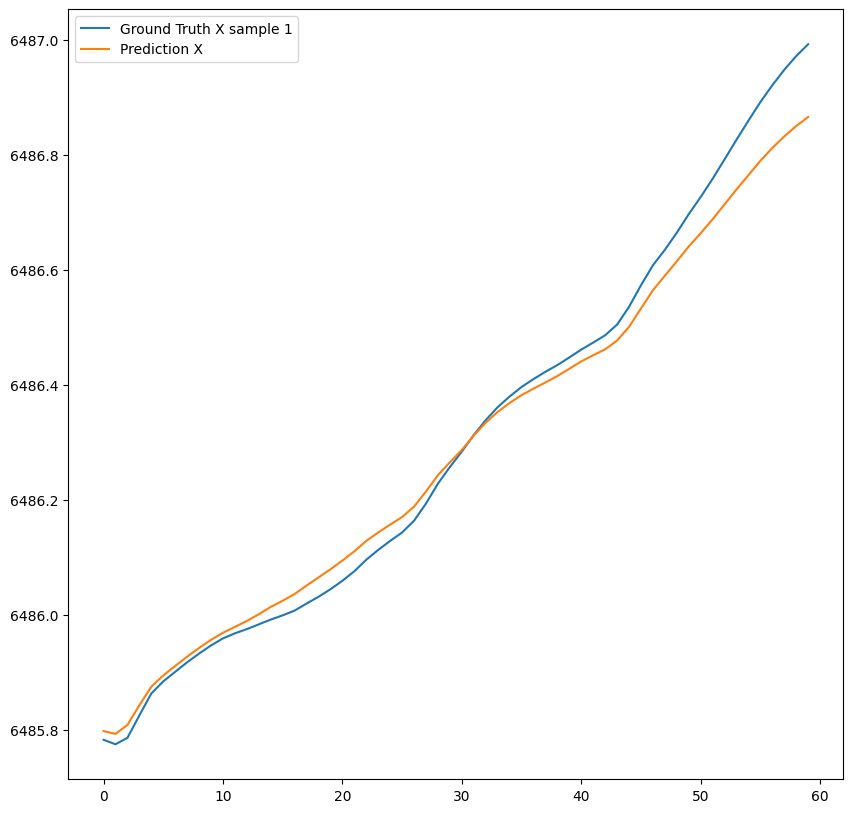

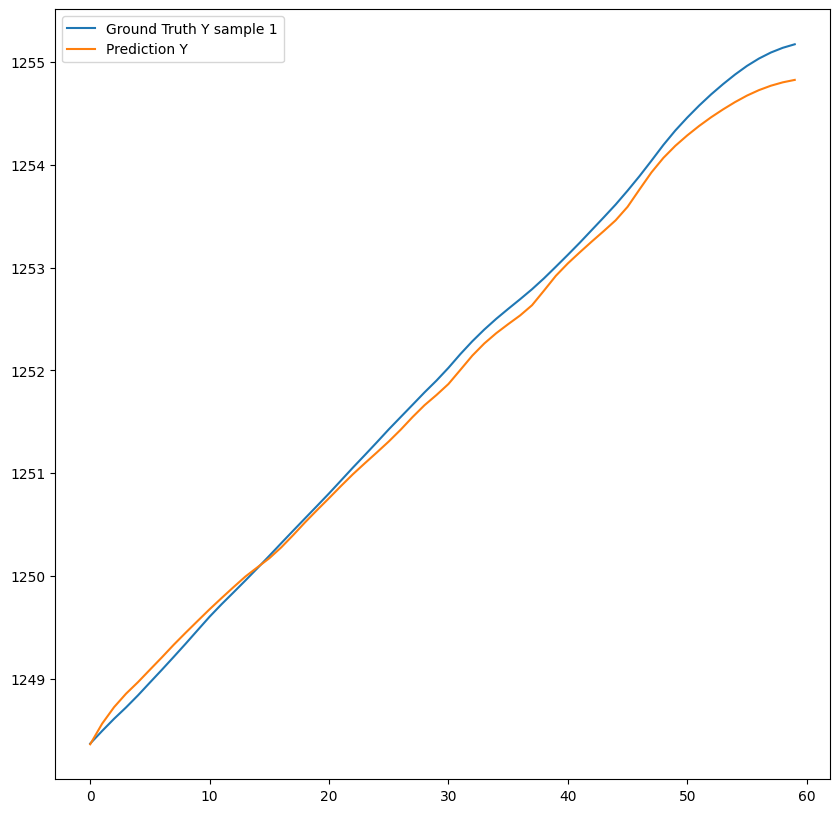

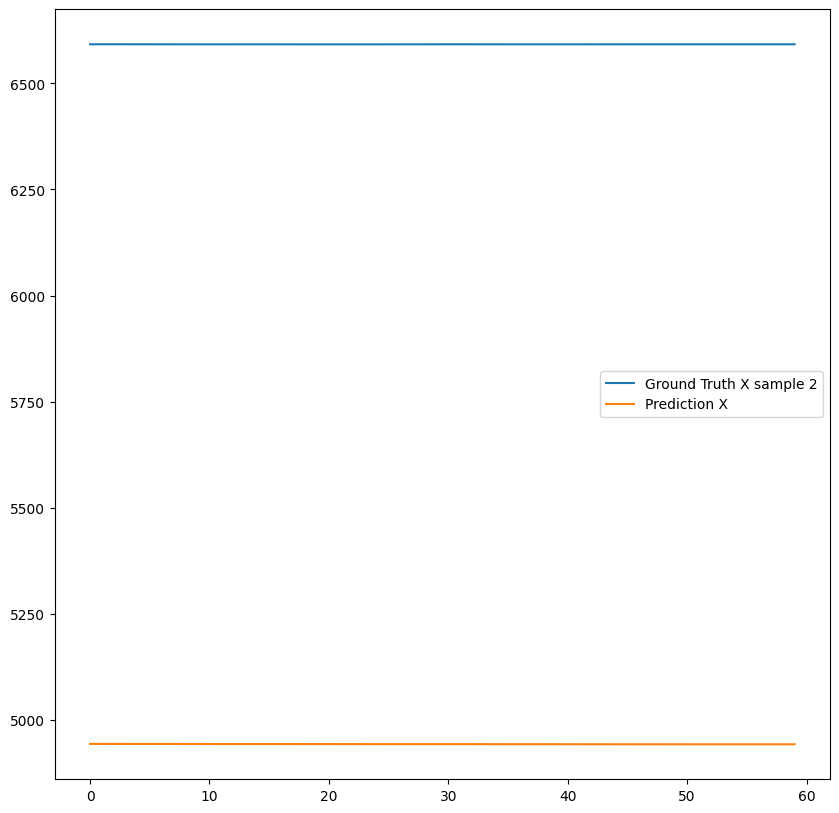

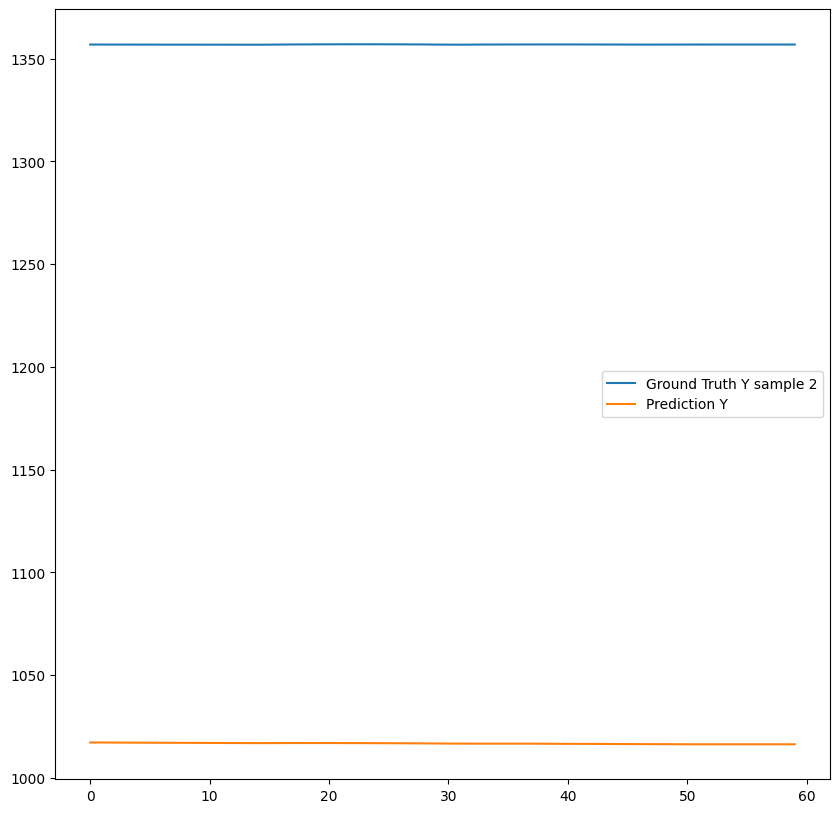

In [71]:
import matplotlib.pyplot as plt
sample_x, sample_y = processed[1][124]
pred_y = models[1](sample_x.unsqueeze(0).to(device)).squeeze(0).detach().cpu().numpy()
sample_x = sample_x.unsqueeze(0).to(device)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sample_y[:, 0], label='Ground Truth X sample 1')
ax.plot(pred_y[:, 0], label='Prediction X')
ax.legend()
plt.show()
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sample_y[:, 1], label='Ground Truth Y sample 1')
ax.plot(pred_y[:, 1], label='Prediction Y')
ax.legend()
plt.show()

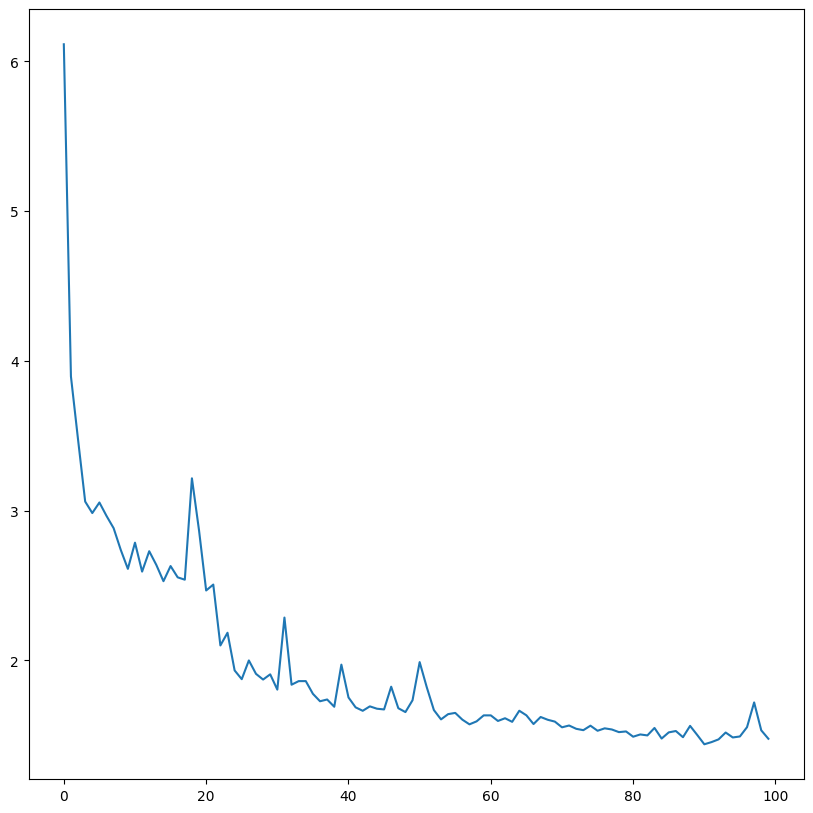

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(val_loss, label='val_loss')
plt.show()